In [244]:
# import Pkg; Pkg.add("LibSerialPort")
# import Pkg; Pkg.add("TickTock")
import Pkg; Pkg.add("PyCall")
# Pkg.build("PyCall")

    Updating registry at `~/.julia/registries/General`


   Resolving package versions...


   Installed PyCall ─ v1.96.1


   Installed Conda ── v1.9.0


    Updating `~/Documents/PlatformIO/Projects/Cartpole/Julia/Project.toml`
  [438e738f] + PyCall v1.96.1
    Updating `~/Documents/PlatformIO/Projects/Cartpole/Julia/Manifest.toml`
  [8f4d0f93] + Conda v1.9.0
  [438e738f] + PyCall v1.96.1
  [81def892] + VersionParsing v1.3.0


    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/915ebe6f0e7302693bdd8eac985797dba1d25662/build.log`


    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/43d304ac6f0354755f1d60730ece8c499980f7ba/build.log`


Precompiling project...


  ✓ PyCall


  1 dependency successfully precompiled in 7 seconds (143 already precompiled)


    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/915ebe6f0e7302693bdd8eac985797dba1d25662/build.log`


    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/43d304ac6f0354755f1d60730ece8c499980f7ba/build.log`


In [354]:
using LibSerialPort
using TickTock
using Plots
using PyCall


list_ports()
ports = get_port_list()

/dev/cu.wlan-debug
	Description:	wlan-debug
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.Bluetooth-Incoming-Port
	Description:	Bluetooth-Incoming-Port
	Transport type:	SP_TRANSPORT_NATIVE
/dev/cu.usbserial-56230387121
	Description:	USB Single Serial
	Transport type:	SP_TRANSPORT_NATIVE


3-element Vector{String}:
 "/dev/cu.wlan-debug"
 "/dev/cu.Bluetooth-Incoming-Port"
 "/dev/cu.usbserial-56230387121"

In [355]:
ports

3-element Vector{String}:
 "/dev/cu.wlan-debug"
 "/dev/cu.Bluetooth-Incoming-Port"
 "/dev/cu.usbserial-56230387121"

## Helper functions and useful constants

In [400]:
ENCODER_LINEAR_ANGULAR_RATIO_CM = 0.6389; # Old: 0.602
ENCODER_LINEAR_ANGULAR_RATIO_M = ENCODER_LINEAR_ANGULAR_RATIO_CM / 100; # Old: 0.00602
ENCODER_ELBOW_ANGULAR_RATIO= 0.2;
ENCODER_SHOULDER_ANGULAR_RATIO = 1.0;
MOTOR_LINEAR_RPM_TO_CMPS = 50; 

decode_list = [
"linear_position", 
"linear_velocity", 
"shoulder_position", 
"shoulder_velocity", 
"elbow_position", 
"elbow_velocity",
"requested_vel_1",
"requested_vel_2",
"serial_tx_time",
# "time_since_last_command",
]

function write_motors(sp, linear_vel, elbow_vel)
    # max prescision of 3 decimal places
    linear_vel = round(linear_vel * MOTOR_LINEAR_RPM_TO_CMPS, digits=3) 
    elbow_vel = round(elbow_vel, digits=3)
    string_to_write = "<" * string(linear_vel) * ", " * string(elbow_vel) * ">"
    write(sp, string_to_write)
end


# Forward declare for runtime optimization
length_decode = length(decode_list)
length_decode_min_1 = length_decode - 1
length_decode_plus_1 = length_decode + 1

function safe_read(sp)
    timeout = 10
    while(timeout > 0)
        encoderData = readline(sp)
        try # catch byte errors in encoderData.decode
            encoderData = split(encoderData, ",")
            encoderData = encoderData[1:length_decode]
            encoderData = [parse(Float64, x) for x in encoderData]
            if length(encoderData) == length_decode # account for the \r\n 
                encoderData[1] *= ENCODER_LINEAR_ANGULAR_RATIO_CM
                encoderData[2] *= ENCODER_LINEAR_ANGULAR_RATIO_CM
                sp_flush(sp, SP_BUF_BOTH)
                return encoderData
            end
            timeout -= 1
            # println("Timeout during Read 1")
        catch
            timeout -= 1
            # println("Timeout during Read 0")
        end
    end
    println("Timeout during Read")
end

function busy_sleep(time_s)
    start = time()
    while (time() - start) < time_s
    end
end

busy_sleep (generic function with 1 method)

In [357]:
# Demo read

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 256000)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)
println(safe_read(sp))
write_motors(sp, 0, 0)
close(sp)

[0.4127294, 0.044723000000000006, -1.766, -0.121, 0.0, 0.0, 0.0, 0.0, 400.0]


## Demo busy sleep vs os sleep accuracy

In [358]:
start = time()
sleep(1)
elapsed = (time() - start)

1.0036239624023438

In [359]:
start = time()
busy_sleep(1)
elapsed = (time() - start) 

1.0084099769592285

## Tune Linear Actuator velocity

In [438]:
# set the acceleration to 100 for 1 second with dt of 1ms

loop_dt = 0.01
# logging_dt = 0.01
# logging_period = logging_dt / loop_dt
tf = 0.5
t_vec = 0:loop_dt:tf
N = length(t_vec)
linearPositions = zeros(N)
elbowPositions = zeros(N)
linearVelocities = zeros(N)
elbowVelocities = zeros(N)
shoulderPositions = zeros(N)
shoulderVelocities = zeros(N)
elbowRequested = zeros(N)
linearRequested = zeros(N)
linearTransmitted = zeros(N)
loop_time_ms_array = zeros(N)
loop_time_ms_array_2 = zeros(N)
SECONDS_TO_MILLISECONDS = 1000
print("N: ", N, "\n")

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 256000)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)

tick()
for i in 1:N
    start_iter = time()


    if (i < N/3)
        speed = 0
    elseif (i < 2*N/3)
        speed = 50
    else
        speed = 0
    end

    write_motors(sp, speed, speed)
    encoder_data = safe_read(sp)

    linearPositions[i] = encoder_data[1]
    linearVelocities[i] = encoder_data[2]
    shoulderPositions[i] = encoder_data[3]
    shoulderVelocities[i] = encoder_data[4]
    elbowPositions[i] = encoder_data[5]
    elbowVelocities[i] = encoder_data[6]
    linearRequested[i] = encoder_data[7]
    elbowRequested[i] = encoder_data[8]
    # serial_tx_time[i] = encoder_data[9]
    linearTransmitted[i] = speed


    loop_time_ms = (time() - start_iter)
    loop_time_ms_array[i] = loop_time_ms
    time_to_sleep = max(loop_dt - loop_time_ms, 0)
    busy_sleep(time_to_sleep) # micro seconds
    loop_time_ms_2 = (time() - start_iter)
    loop_time_ms_array_2[i] = time_to_sleep
    # busy_sleep(dt) # micro seconds
end
tock()

write_motors(sp, 0, 0)
close(sp)

N: 51


┌ Info:  started timer at: 2023-07-13T06:58:53.307
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:54
┌ Info:          0.542124167s: 542 milliseconds
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:62


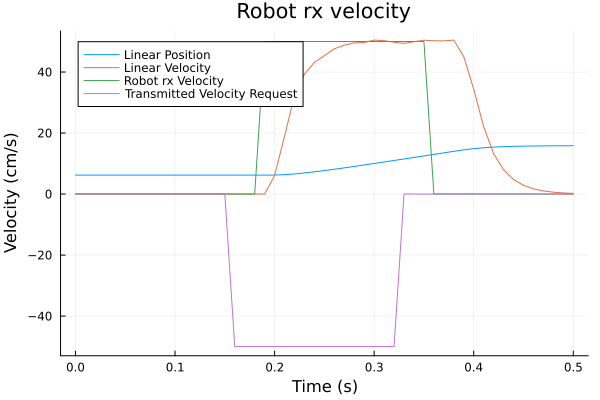

In [431]:
# plot linear position
plot(t_vec, linearPositions, title="Linear Position", xlabel="Time (s)", ylabel="Position (cm)", label = "Linear Position")
plot!(t_vec, linearVelocities, title="Linear Velocity", xlabel="Time (s)", ylabel="Velocity (cm/s)", label = "Linear Velocity")
plot!(t_vec, -1 * linearRequested / MOTOR_LINEAR_RPM_TO_CMPS, title="Robot rx velocity", xlabel="Time (s)", ylabel="Velocity (cm/s)", label = "Robot rx Velocity")
plot!(t_vec, linearTransmitted, xlabel="Time (s)", ylabel="Velocity (cm/s)", label = "Transmitted Velocity Request")

In [422]:
# find index where linearRequested is not 0
index = findfirst(linearRequested .!= 0)
index_2 = findfirst(linearTransmitted .!= 0)

println("index: ", index, " index_2: ", index_2, " index_2 - index: ", index_2 - index, " (index_2 - index) * dt: ", (index_2 - index) * loop_dt)

index: 169 index_2: 167 index_2 - index: -2 (index_2 - index) * dt: -0.02


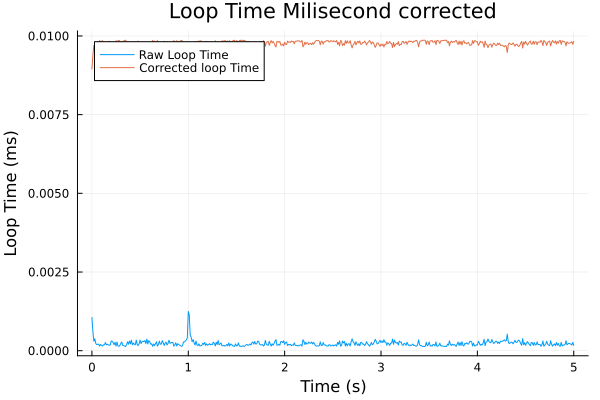

In [423]:
# plot loop_time_micros
plot(t_vec, loop_time_ms_array, title="Loop Time Milisecond", xlabel="Time (s)", ylabel="Loop Time (ms)", label="Raw Loop Time")
plot!(t_vec, loop_time_ms_array_2, title="Loop Time Milisecond corrected", xlabel="Time (s)", ylabel="Loop Time (ms)", label="Corrected loop Time")

In [325]:
start_position = linearPositions[1]
end_position = linearPositions[end] 
println("Linear Position diff: ", end_position - start_position, " cm")

Linear Position diff: 0.0 cm


#### Old stuff

┌ Warning: Keyword argument markerstrokestyle not supported with Plots.GRBackend().  Choose from: annotations, arrow, aspect_ratio, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, connections, contour_labels, discrete_values, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefontsize, guidefontvalign, html_output_format, inset_subplots, label, layout, left_margin, legend_background_color, legend_font_color, legend_font_family, legend_font_halign, legend_font_pointsize, legend_font_rotation, legend_font_valign, legend_foreground_color, leg

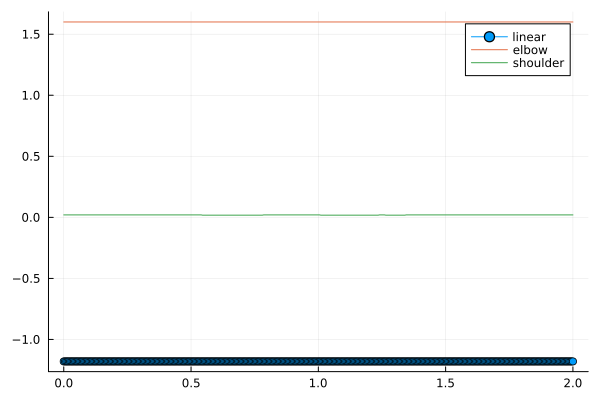

In [14]:
# plot the various positions over time
plot(t_vec, linearPositions * ENCODER_LINEAR_ANGULAR_RATIO_CM, label="linear", marker=:dot)
plot!(t_vec, elbowPositions, label="elbow")
plot!(t_vec, shoulderPositions, label="shoulder")

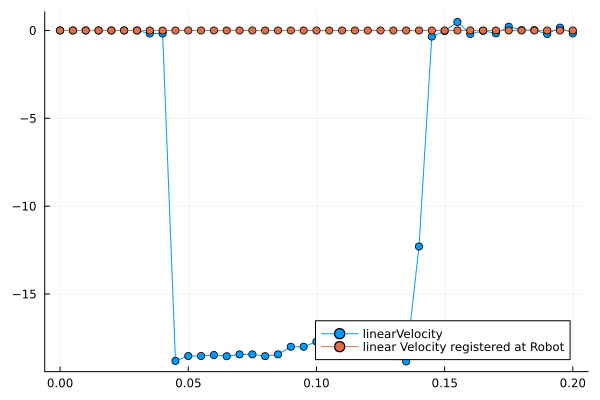

In [166]:
# plot the various velocities over time, each point should be a dot
plot(t_vec, linearVelocities * ENCODER_LINEAR_ANGULAR_RATIO_CM, label="linearVelocity", marker=:dot)
# plot!(t_vec, elbowVelocities, label="elbow", marker=:dot)
# plot!(t_vec, shoulderVelocities, label="shoulder", marker=:dot)
# plot!(t_vec, elbowRequested, label="elbow requested", marker=:dot)
plot!(t_vec, linearRequested / -1000, label="linear Velocity registered at Robot", marker=:dot)

Problems: 
* Inconsistent sleep time

In [76]:
# import Pkg; Pkg.add("JLD2")
using JLD2
traj = jldopen("./cartpole_swingup.jld2", "r")
traj = jldopen("./cartpole_swingup_100ms_10s.jld2", "r")
X = traj["X"]

101-element Vector{Vector{Float64}}:
 [-3.0984724878352865e-30, -3.5129308251160064e-30, -1.5627575792769598e-30, 1.2547750383410388e-30]
 [-0.0039375044093136686, 0.009638688608895135, -0.07717096570291737, 0.18488484041709527]
 [-0.011618957926831715, 0.026127639073725995, -0.07376453124904027, 0.1314232005136461]
 [-0.019516896462457158, 0.036872623229787745, -0.08244334610340306, 0.07471038201611803]
 [-0.028855482691678095, 0.0422890292848597, -0.10344656649520784, 0.029200815711398216]
 [-0.04063843432740988, 0.04353135442904933, -0.13201018599303266, -0.005367521243017284]
 [-0.05535031824220925, 0.041486332749711814, -0.16256062569428595, -0.03386456965386749]
 [-0.07191765243820875, 0.03401949680273698, -0.17000000993863357, -0.10938862036395777]
 [-0.08879639354748478, 0.019146497286937087, -0.17000000996444942, -0.17593346006017047]
 [-0.10563631067455195, -0.00041898142800650515, -0.1700000099582367, -0.19937572840810625]
 ⋮
 [-0.0833386532619973, 1.5810651812993943, -0.170

In [77]:
# extract the 3rd element of the vector of vectors and save that as a velocity vector
velocity = [x[3] for x in X]
println(maximum(velocity))
println(minimum(velocity))

position = [x[1] for x in X]
println(maximum(position))
println(minimum(position))

0.1700000099999786
-0.17000000999996973


0.0
-0.1712805315020025


In [13]:
speed_mult = 22222
dt = 0.1
tf = 10
t_vec = 0:dt:tf
N = length(t_vec)
linearPositions = zeros(N)
elbowPositions = zeros(N)
linearVelocities = zeros(N)
elbowVelocities = zeros(N)
shoulderPositions = zeros(N)
shoulderVelocities = zeros(N)
elbowRequested = zeros(N)
linearRequested = zeros(N)

dt = 0.096

println(N)

sp = LibSerialPort.open("/dev/cu.usbserial-56230387121", 115200)
set_flow_control(sp)
sp_flush(sp, SP_BUF_BOTH)

tick()
for i in 1:N
    encoders = readline(sp)
    encodersSplit = split(encoders, ",")

    linearPositions[i] = parse(Float64, encodersSplit[1])
    linearVelocities[i] = parse(Float64, encodersSplit[2])
    shoulderPositions[i] = parse(Float64, encodersSplit[3])
    shoulderVelocities[i] = parse(Float64, encodersSplit[4])
    elbowPositions[i] = parse(Float64, encodersSplit[5])
    elbowVelocities[i] = parse(Float64, encodersSplit[6])
    # elbowRequested[i] = parse(Float64, encodersSplit[7])
    # linearRequested[i] = parse(Float64, encodersSplit[8])


    # convert to string with precision 2 decimal places
    velocity_string = string(round(velocity[i] * speed_mult, digits=1))
    command = "<0, " * velocity_string * ">"
    write(sp, command)
    write(sp, "<0, 0>")
    # println(command)

    sleep(dt) # micro seconds
end
tock()

write(sp, "<0, 0>") # first is elbow, second is linear rail
close(sp)


101


┌ Info:  started timer at: 2023-05-05T10:11:37.296
└ @ TickTock /Users/saraltayal/.julia/packages/TickTock/fGILW/src/TickTock.jl:54


OS error code 6: Device not configured


ErrorException: libserialport returned SP_ERR_FAIL - Host OS reported a failure.